In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
with open("../data/pickles/cardiac_mortality_obesity_dm_df_by_state.pkl", "rb") as picklefile:
    state_mortality_dict = pickle.load(picklefile)

Let's figure out cross-validation first, and then we can tackle neural nets with pytorch.

In order to tackle cross-validation, what we should do is make different models, and run cross-validation on each, and compare models. First, we need to clean up the dataframe for each state.

## Truncating and interpolating state dataframes

To clean up the dataframes for each state, first we know that the end date for which we have date is 2015-01-01, since that's the last date for which we have obesity and diabetes prevalence data. So we'll filter out all dates after that, and then check to see how many NaNs are still in the target variable. If 25% or more of the target variable time series are NaNs, we'll drop that state's dataframe and not analyze it. If it's less than 25%, we'll impute the data using linear interpolation.

In [3]:
def truncate_and_interpolate_df(df, end_date, target_variable, null_ratio_drop=0.25):
    truncated_df = df[df.index <= end_date].copy()
    null_target_data_points = truncated_df[target_variable].isnull().sum()
    if null_target_data_points/len(df[target_variable]) > 0.25:
#         print("Unable to interpolate, too many NaNs.")
        return None
    elif null_target_data_points == 0:
#         print("no need to interpolate, no NaNs.")
        return truncated_df
    else:
#         print(f"interpolated {null_target_data_points} NaNs.")
        truncated_df[target_variable] = truncated_df[target_variable].interpolate(method='linear')
        return truncated_df

Now, let's make a clean dictionary of dataframes for each state.

In [67]:
clean_dict_of_state_dfs = {}
end_date = pd.to_datetime('January 1 2015')
target_variable = 'mortality_per_100k'

for state, df in state_mortality_dict.items():
#     print(f"The current state is {state}")
    temp_df = truncate_and_interpolate_df(df=df, end_date=end_date, target_variable=target_variable)
    if temp_df is None:
        pass
    else:
        clean_dict_of_state_dfs[state] = temp_df

In [2]:
%%bash
ls ../data/pickles

cardiac_mortality_obesity_dm_df_by_state.pkl
interpol_truncated_MI_mortality_per_state_dict.pkl
myocardial_infarction_df_state_mortality_dict.pkl
state_population_by_year_dict.pkl


In [7]:
with open("../data/pickles/interpol_truncated_MI_mortality_per_state_dict.pkl", "wb") as picklefile:
    pickle.dump(clean_dict_of_state_dfs, picklefile)

## Load truncated and interpolated dataframe

In [3]:
with open("../data/pickles/interpol_truncated_MI_mortality_per_state_dict.pkl", "rb") as picklefile:
    clean_dict_of_state_dfs = pickle.load(picklefile)

In [7]:
alabama = clean_dict_of_state_dfs['Alabama']

In [8]:
california = clean_dict_of_state_dfs['California']

Let's look at how many times we would have to difference the target variable in order to make it stationary; we can do this by looking at the standard deviation for the series itself, its difference, and its second order difference, etc. The smallest std implies that the series is stationary at that degree of difference.

In [9]:
print(california['mortality_per_100k'].std())
print(california['mortality_per_100k'].diff().std())
print(california['mortality_per_100k'].diff().diff().std())

0.7612392644026806
0.31938588845854493
0.48041745875819164


In [11]:
print(alabama['mortality_per_100k'].std())
print(alabama['mortality_per_100k'].diff().std())
print(alabama['mortality_per_100k'].diff().diff().std())

1.299882642192452
0.6508563102638677
1.0678524222116754


Figure(432x288)
Figure(432x288)


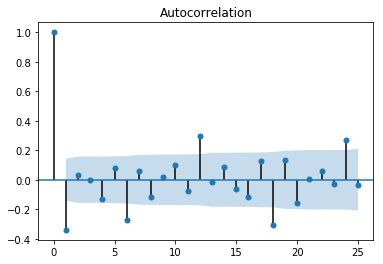

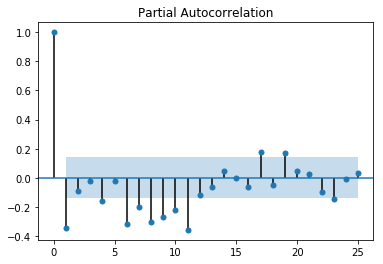

In [12]:
print(plot_acf(alabama['mortality_per_100k'].diff()[1:], lags=25))
print(plot_pacf(alabama['mortality_per_100k'].diff()[1:], lags=25))

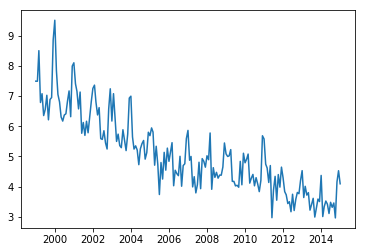

In [167]:
plt.plot(alabama['mortality_per_100k'])

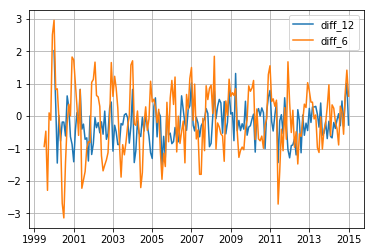

In [13]:
# We can see here that when we subtract 12 months back, the variance of the series is less than if we difference
# at 6 months back. I think this is how we take out the annual seasonality that is evident in the target variable.
plt.plot(alabama['mortality_per_100k'].diff(12), label='diff_12')
plt.plot(alabama['mortality_per_100k'].diff(6), label='diff_6')
plt.legend()
plt.grid()

Now, using the parameters that we got from doing gridsearch on the California target variable, looking at the ACF and pACF plots, I'm going to manually populate one of my dataframes and then run these other types of models on the dataframes, and see how it does.

In [14]:
california['mortality_per_100k_diff'] = california['mortality_per_100k'].diff()

california['mort_per_100k_diff_lag1'] = california['mortality_per_100k_diff'].shift()

california['mort_per_100k_diff_lag_MA1'] = california['mort_per_100k_diff_lag1'].rolling(2).mean()

california['mort_per_100k_diff_seasonal_lag1'] = california['mortality_per_100k_diff'].shift(12)

In [15]:
california.columns

Index(['Deaths', 'obesity_prevalence', 'diabetes_prevalence', 'Population',
       'mortality_per_100k', 'mortality_per_100k_diff',
       'mort_per_100k_diff_lag1', 'mort_per_100k_diff_lag_MA1',
       'mort_per_100k_diff_seasonal_lag1'],
      dtype='object')

In [16]:
california_copy = california.dropna()

In [17]:
california_copy.head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k,mortality_per_100k_diff,mort_per_100k_diff_lag1,mort_per_100k_diff_lag_MA1,mort_per_100k_diff_seasonal_lag1
Month,,,,,,,,,
2000-02-01,1351.0,39.933333,7.058333,3.392230e+07,3.982631,-1.408308,-0.205886,0.688642,-0.162609
2000-03-01,1535.0,40.666667,7.016667,3.397295e+07,4.518301,0.535670,-1.408308,-0.807097,0.111817
2000-04-01,1354.0,41.400000,6.975000,3.402360e+07,3.979591,-0.538710,0.535670,-0.436319,-0.349804
2000-05-01,1264.0,42.133333,6.933333,3.407425e+07,3.709546,-0.270045,-0.538710,-0.001520,-0.482994
2000-06-01,1272.0,42.866667,6.891667,3.412490e+07,3.727483,0.017937,-0.270045,-0.404377,-0.333534


In [18]:
X = california_copy[['obesity_prevalence', 'diabetes_prevalence', 'mort_per_100k_diff_lag1', 'mort_per_100k_diff_lag_MA1', 'mort_per_100k_diff_seasonal_lag1']]
y = california_copy['mortality_per_100k_diff']

In [21]:
lin_regr = LinearRegression()

In [22]:
import math

In [23]:
X_train = X[0:math.ceil(len(y)*0.75)]
X_test = X[math.ceil(len(y)*0.75):]
y_train = y[0:math.ceil(len(y)*0.75)]
y_test = y[math.ceil(len(y)*0.75):]

In [24]:
lin_regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
y_test_pred = lin_regr.predict(X_test)

In [26]:
y_test_pred = pd.Series(y_test_pred, index=y_test.index)

In [27]:
lin_regr.score(X_test, y_test)

0.2231114597501509

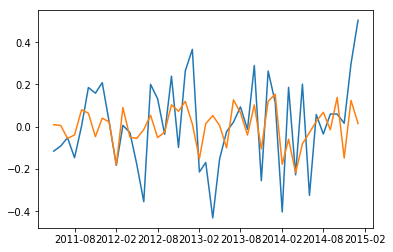

In [28]:
plt.plot(y_test, label='y true')
plt.plot(y_test_pred, label='y predicted')
plt.show()

In [29]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import math
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)  

models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    val_rmse_scores = []
    final_rmse_scores = []
    for train_index, test_index in tscv.split(X):
        nested_train_length = math.ceil(0.75 * len(train_index))
        X_train, X_final_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_final_test = y.iloc[train_index].values.reshape(-1,), y.iloc[test_index].values.reshape(-1,)
        
        X_nested_train = X_train[:nested_train_length]
        X_nested_valtest = X_train[nested_train_length:]
        
        y_nested_train = y_train[:nested_train_length]
        y_nested_valtest = y_train[nested_train_length:]
        
        grid.fit(X_nested_train, y_nested_train)
        
        y_valtest_pred = grid.predict(X_nested_valtest)
        
        val_mse_score = -1.0*grid.score(X_nested_valtest,y_nested_valtest)
        val_rmse_score = np.sqrt(val_mse_score)
        val_rmse_scores.append(np.round(val_rmse_score,4))
        avg_val_mse_score = np.mean(val_rmse_scores)
        
        y_finaltest_pred = grid.predict(X_final_test)
        final_mse_score = -1.0*grid.score(X_final_test,y_final_test)
        final_rmse_score = np.sqrt(final_mse_score)
        final_rmse_scores.append(np.round(final_rmse_score,4))
        avg_final_mse_score = np.mean(final_rmse_scores)
        
        s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
        
        grids[name] = grid
        
    print(f'Model name: {name}')
    print(f'Val RMSE scores: {val_rmse_scores}')
    print(f'Model Val RMSE performance: {avg_val_mse_score}')
    print(f'Final RMSE scores: {final_rmse_scores}')
    print(f'Model Final RMSE performance: {avg_final_mse_score}')
    print('\n')

TimeSeriesSplit(max_train_size=None, n_splits=10)
Model name: Linear Regresion
Val RMSE scores: [1.0704, 0.346, 0.3246, 0.1927, 0.2589, 0.2474, 0.2011, 0.1988, 0.1668, 0.1617]
Model Val RMSE performance: 0.31684
Final RMSE scores: [2.4796, 0.4798, 0.236, 0.2793, 0.2557, 0.1867, 0.2095, 0.1079, 0.2073, 0.2059]
Model Final RMSE performance: 0.46476999999999996


Model name: SVR
Val RMSE scores: [0.2274, 0.2172, 0.3299, 0.2189, 0.2986, 0.2866, 0.1951, 0.2605, 0.1805, 0.1786]
Model Val RMSE performance: 0.23933
Final RMSE scores: [0.6334, 0.3371, 0.2311, 0.3447, 0.2744, 0.1883, 0.2449, 0.1119, 0.2276, 0.2394]
Model Final RMSE performance: 0.28328


Model name: Decision Tree
Val RMSE scores: [0.2629, 0.2444, 0.2695, 0.2205, 0.1991, 0.2652, 0.2149, 0.2453, 0.2162, 0.2114]
Model Val RMSE performance: 0.23494
Final RMSE scores: [0.3532, 0.2488, 0.2551, 0.2237, 0.2486, 0.1904, 0.3006, 0.1416, 0.2363, 0.2826]
Model Final RMSE performance: 0.24809


Model name: Random Forest
Val RMSE scores: [0.2

In [31]:
grids.keys()

dict_keys(['Linear Regresion', 'SVR', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees'])

In [37]:
gbtree = grids['Gradient Boosted Trees'].best_estimator_

In [38]:
y_pred = gbtree.predict(X)

In [41]:
y_pred_series = pd.Series(y_pred, index = y.index)

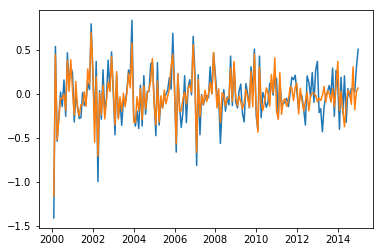

In [42]:
plt.plot(y, label='actual y')
plt.plot(y_pred_series, label='predicted y')
plt.show()

## Raw data, not differenced to make it stationary

Let's see how these other models do if they are given the raw data that has not been differenced. That also means using AR-1 and MA-1 on the undifferenced data.

In [10]:
california = clean_dict_of_state_dfs['California'].copy()

In [11]:
california.drop(columns=['Deaths', 'Population'], inplace=True)

In [12]:
california['mort_per_100k_lag1'] = california['mortality_per_100k'].shift()
california['mort_per_100k_lag1_MA2'] =california['mort_per_100k_lag1'].rolling(2).mean()
california.dropna(inplace=True)

In [13]:
X = california.loc[:, california.columns != 'mortality_per_100k']
y = california['mortality_per_100k']

In [14]:
X.head()

,obesity_prevalence,diabetes_prevalence,mort_per_100k_lag1,mort_per_100k_lag1_MA2
Month,,,,
1999-03-01,41.116667,6.60,4.744970,4.826275
1999-04-01,40.925000,6.65,4.856788,4.800879
1999-05-01,40.733333,6.70,4.506983,4.681885
1999-06-01,40.541667,6.75,4.023989,4.265486
1999-07-01,40.350000,6.80,3.690455,3.857222


In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import math
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)  

models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    val_rmse_scores = []
    final_rmse_scores = []
    for train_index, test_index in tscv.split(X):
        nested_train_length = math.ceil(0.75 * len(train_index))
        X_train, X_final_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_final_test = y.iloc[train_index].values.reshape(-1,), y.iloc[test_index].values.reshape(-1,)
        
        X_nested_train = X_train[:nested_train_length]
        X_nested_valtest = X_train[nested_train_length:]
        
        y_nested_train = y_train[:nested_train_length]
        y_nested_valtest = y_train[nested_train_length:]
        
        grid.fit(X_nested_train, y_nested_train)
        
        y_valtest_pred = grid.predict(X_nested_valtest)
        
        val_mse_score = -1.0*grid.score(X_nested_valtest,y_nested_valtest)
        val_rmse_score = np.sqrt(val_mse_score)
        val_rmse_scores.append(np.round(val_rmse_score,4))
        avg_val_mse_score = np.mean(val_rmse_scores)
        
        y_finaltest_pred = grid.predict(X_final_test)
        final_mse_score = -1.0*grid.score(X_final_test,y_final_test)
        final_rmse_score = np.sqrt(final_mse_score)
        final_rmse_scores.append(np.round(final_rmse_score,4))
        avg_final_mse_score = np.mean(final_rmse_scores)
        
        s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
        
        grids[name] = grid
        
    print(f'Model name: {name}')
    print(f'Val RMSE scores: {val_rmse_scores}')
    print(f'Model Val RMSE performance: {avg_val_mse_score}')
    print(f'Final RMSE scores: {final_rmse_scores}')
    print(f'Model Final RMSE performance: {avg_final_mse_score}')
    print('\n')

TimeSeriesSplit(max_train_size=None, n_splits=10)
Model name: Linear Regresion
Val RMSE scores: [0.8185, 0.4348, 0.2869, 0.3268, 0.2804, 0.3621, 0.297, 0.2309, 0.2007, 0.202]
Model Val RMSE performance: 0.34401
Final RMSE scores: [0.8268, 0.264, 0.3256, 0.3017, 0.3777, 0.2213, 0.3022, 0.1525, 0.2084, 0.2255]
Model Final RMSE performance: 0.32056999999999997


Model name: SVR
Val RMSE scores: [0.2499, 0.4057, 0.6535, 0.4962, 0.9357, 0.4798, 0.398, 0.3758, 0.2732, 0.5494]
Model Val RMSE performance: 0.48172000000000004
Final RMSE scores: [0.3992, 0.5688, 0.661, 0.8268, 0.7233, 0.6601, 0.3895, 0.472, 0.7528, 0.8275]
Model Final RMSE performance: 0.6280999999999999


Model name: Decision Tree
Val RMSE scores: [0.2171, 0.3832, 0.3496, 0.4696, 0.3457, 0.418, 0.3475, 0.2996, 0.2452, 0.2338]
Model Val RMSE performance: 0.33093000000000006
Final RMSE scores: [0.3549, 0.3897, 0.3935, 0.5991, 0.5123, 0.3868, 0.4527, 0.2447, 0.3452, 0.3139]
Model Final RMSE performance: 0.39927999999999997


Model

In [16]:
gbtree = grids['Gradient Boosted Trees'].best_estimator_
y_pred = gbtree.predict(X)
y_pred_series = pd.Series(y_pred, index = y.index)

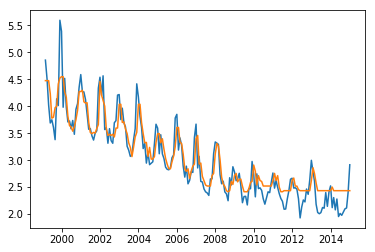

In [17]:
plt.plot(y, label='actual y')
plt.plot(y_pred_series, label='predicted y')
plt.show()

/Users/joycelee/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function n_features is deprecated; Attribute n_features was deprecated in version 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


4

In [20]:
gbtree.feature_importances_

array([0.27, 0.29, 0.28, 0.16])

## Combining data from multiple states

Let's try combining the data from multiple states and seeing what happens to the different models.

In [25]:
california = clean_dict_of_state_dfs['California']
alabama = clean_dict_of_state_dfs['Alabama']

In [27]:
california.head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k
Month,,,,,
1999-01-01,1644.0,41.500000,6.50,33499204.0,4.907579
1999-02-01,1591.0,41.308333,6.55,33530241.0,4.744970
1999-03-01,1630.0,41.116667,6.60,33561278.0,4.856788
1999-04-01,1514.0,40.925000,6.65,33592315.0,4.506983
1999-05-01,1353.0,40.733333,6.70,33623352.0,4.023989


In [34]:
california.shape

(193, 5)

In [35]:
california['state'] = ['california'] * california.shape[0]

In [37]:
alabama['state'] = ['alabama'] * alabama.shape[0]

In [38]:
california_alabama = pd.concat([california, alabama])

In [44]:
california_alabama.sort_index(inplace=True)

In [45]:
california_alabama.head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k,state
Month,,,,,,
1999-01-01,1644.0,41.500000,6.500000,33499204.00,4.907579,california
1999-01-01,332.0,61.400000,7.400000,4430141.00,7.494118,alabama
1999-02-01,1591.0,41.308333,6.550000,33530241.00,4.744970,california
1999-02-01,332.0,60.833333,7.383333,4431554.25,7.491728,alabama
1999-03-01,1630.0,41.116667,6.600000,33561278.00,4.856788,california


In [47]:
z = california_alabama.drop(columns=['Deaths', 'Population', 'state'])

In [48]:
z.head()

,obesity_prevalence,diabetes_prevalence,mortality_per_100k
Month,,,
1999-01-01,41.500000,6.500000,4.907579
1999-01-01,61.400000,7.400000,7.494118
1999-02-01,41.308333,6.550000,4.744970
1999-02-01,60.833333,7.383333,7.491728
1999-03-01,41.116667,6.600000,4.856788


In [49]:
X = z[['obesity_prevalence', 'diabetes_prevalence']]
y = z.mortality_per_100k

In [50]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import math
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)  

models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    val_rmse_scores = []
    final_rmse_scores = []
    for train_index, test_index in tscv.split(X):
        nested_train_length = math.ceil(0.75 * len(train_index))
        X_train, X_final_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_final_test = y.iloc[train_index].values.reshape(-1,), y.iloc[test_index].values.reshape(-1,)
        
        X_nested_train = X_train[:nested_train_length]
        X_nested_valtest = X_train[nested_train_length:]
        
        y_nested_train = y_train[:nested_train_length]
        y_nested_valtest = y_train[nested_train_length:]
        
        grid.fit(X_nested_train, y_nested_train)
        
        y_valtest_pred = grid.predict(X_nested_valtest)
        
        val_mse_score = -1.0*grid.score(X_nested_valtest,y_nested_valtest)
        val_rmse_score = np.sqrt(val_mse_score)
        val_rmse_scores.append(np.round(val_rmse_score,4))
        avg_val_mse_score = np.mean(val_rmse_scores)
        
        y_finaltest_pred = grid.predict(X_final_test)
        final_mse_score = -1.0*grid.score(X_final_test,y_final_test)
        final_rmse_score = np.sqrt(final_mse_score)
        final_rmse_scores.append(np.round(final_rmse_score,4))
        avg_final_mse_score = np.mean(final_rmse_scores)
        
        s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
        
        grids[name] = grid
        
    print(f'Model name: {name}')
    print(f'Val RMSE scores: {val_rmse_scores}')
    print(f'Model Val RMSE performance: {avg_val_mse_score}')
    print(f'Final RMSE scores: {final_rmse_scores}')
    print(f'Model Final RMSE performance: {avg_final_mse_score}')
    print('\n')

TimeSeriesSplit(max_train_size=None, n_splits=10)
Model name: Linear Regresion
Val RMSE scores: [0.9256, 0.9801, 1.1872, 1.7262, 1.7899, 1.8728, 1.4485, 1.216, 1.4375, 1.1842]
Model Val RMSE performance: 1.3768
Final RMSE scores: [1.6705, 1.2024, 1.9124, 2.1277, 2.4903, 1.9915, 1.3532, 1.2362, 1.1412, 0.9893]
Model Final RMSE performance: 1.61147


Model name: SVR
Val RMSE scores: [1.3087, 0.6093, 1.1574, 0.8795, 1.7575, 1.2713, 1.0209, 1.104, 0.6529, 1.2724]
Model Val RMSE performance: 1.10339
Final RMSE scores: [1.8446, 1.249, 1.3498, 1.9163, 1.4483, 1.2792, 1.2419, 1.2966, 1.4502, 1.7745]
Model Final RMSE performance: 1.4850400000000001


Model name: Decision Tree
Val RMSE scores: [0.6889, 0.6778, 0.6578, 0.9876, 1.8904, 1.8024, 0.9361, 0.8497, 1.1306, 0.6209]
Model Val RMSE performance: 1.0242200000000001
Final RMSE scores: [1.8544, 0.7281, 1.0341, 2.1096, 1.6361, 1.3547, 1.1094, 1.043, 0.6813, 0.9146]
Model Final RMSE performance: 1.2465300000000001


Model name: Random Forest
Val